# Two-Particle Self-Consistent approach (TPSC) tutorial

This tutorial is done in four steps

1. You will first learn how to manipulate multivariable Green's functions. 
   You will also convince yourself that for nearest-neighbor non-interacting models, the Fermi surface has perfect    nesting(TPSC-1)

2. You will compute the Lindhard function for the non-interacting susceptibility (TPSC-2)

3. You will then compute the RPA approximation to check the divergence at ($\pi,\pi)$ (TPSC-3)

4. Renormalized spin and charge vertices in TPSC are computed. (TPSC-4)
   
5. The spin susceptibility is computed to show that it does not diverge at finite temperature. (TPSC-5)

6. A challenging exercice with the self-energy (hot spots) is left at the end if you have time. (TPSC-6)

## Lattice Green function

In this notebook, we will first manipulate the Green's function on a square lattice with nearest neighbour hopping $t$, 

\begin{equation}
G_0(\mathbf{k},i\omega_n)=\frac{1}{i\omega_n  + \mu - \epsilon(\mathbf{k})}
\end{equation}

whose dispersion is $\epsilon(\mathbf{k})=-2t(\cos{k_x}+\cos{k_y})$, where $\mathbf{k}$ is a vector in the Brillouin zone (in units where the lattice spacing is unity $a=1$) and $i\omega_n$ is a Matsubara frequency.

In [1]:
# Imports 
%matplotlib inline
from pytriqs.lattice import BravaisLattice, BrillouinZone
from pytriqs.gf import Gf, MeshProduct, MeshBrillouinZone, MeshImFreq, Idx
from pytriqs.plot.mpl_interface import plt
import numpy as np
from math import cos, pi

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Regroup some parameters of the computation used later
beta = 1/0.4 # Inverse temperature
t = 1.0      # Hopping   
n_k = 128    # Number of points in the Brillouin Zone mesh (for each dimension)
n_w = 128    # Number of Matsubara frequencies
mu = 0       # Chemical potential

## A mesh on a Brillouin Zone

We first define a simple Bravais lattice (`BravaisLattice`) in 2 dimensions with basis vectors $\hat{e}_x = (1, 0, 0)$ and $\hat{e}_y=(0, 1, 0)$, and given the bravais lattice we construct the reciprocal (momentum) space Brillouin zone (`BrillouinZone`).

In [3]:
BL = BravaisLattice([(1, 0, 0), (0, 1, 0)]) # Two unit vectors in R3
BZ = BrillouinZone(BL) 

The complex valued Green's function $G(\mathbf{k}, i\omega_n) $ is represented on the cartesian product mesh : $ (\mathbf{k} \times i\omega_n) \rightarrow {\mathcal{C}}$. 

We construct $G$ by first defining the two separate meshes in momentum space $\mathbf{k}$ (`MeshBrillouinZone`) and frequency space $i\omega_n$ (`MeshImFreq`) and then use the `MeshProduct` of these meshes as the mesh for $G(\mathbf{k}, i\omega_n)$.

In [4]:
kmesh = MeshBrillouinZone(BZ, n_k=n_k)
wmesh = MeshImFreq(beta=beta, S='Fermion', n_max=n_w)

g0 = Gf(mesh=MeshProduct(kmesh, wmesh), target_shape=[])  # g0(k,omega), scalar valued

print g0

Green Function  with mesh Brillouin Zone Mesh  with linear dimensions (128 128 1), Domain: Brillouin Zone with repiprocal matrix 
[[6.28319,0,0]
 [0,6.28319,0]
 [0,0,6.28319]], Matsubara Freq Mesh of size 256, Domain: Matsubara domain with beta = 2.5, statistic = Fermion, positive_only : 0 and target_rank 0: 



To fill the Green's function we construct a function for the dispersion $\epsilon(\mathbf{k})$ and set each element of $G$ by looping over the momentum and frequency meshes.

In [5]:
def eps(k):
    return -2 * t* (cos(k[0]) + cos(k[1]))

# NB : loop is a bit slow in python ...
for k in g0.mesh[0]:
    for w in g0.mesh[1]:
        g0[k, w] = 1/(w - eps(k))

## (Optional) More advanced

The python is quite slow, as any serious (double !) loop in Python.

It is a good opportunity to illustrate a bit the C++ layer of the TRIQS library, 
using the TRIQS/cpp2py tool to wrap Python and C++ in a simple case.

We first import an ipython "magic" command `%%cpp2py` :

In [6]:
%reload_ext cpp2py.magic

The function `compute_g0` below is written in C++. 
It takes a (view to a) Green function, and the hopping $t$
and does the same computation as above.

When executing the "magic" cell, the C++ is analysed by the Clang compiler, 
a wrapping code (to expose it to Python and convert its argument) is generated,
compiled. The whole is linked into a module, which is loaded automatically,
so the `compute_g0` function is available in Python.

`NB : We could show how to acces g0.data to vectorize its initialization`

In [7]:
%%cpp2py -C pytriqs

#include <triqs/gfs.hpp>
using namespace triqs::gfs;

void compute_g0(gf_view<cartesian_product<brillouin_zone, imfreq>, scalar_valued> g, double t) {
    
    auto eps = [t](auto const & k) { return (-2*t) *(cos(k[0]) + cos(k[1]));}; // a C++ lambda
    for (auto [k,w] : g.mesh()) // loop on points
       g[k,w] = 1/(w - eps(k)); // k,w are points on the grid, 
                                // and casted in points on the k mesh, and a Matsubara frequency resp.
}

In [9]:
# we call the function and show that we get the same answer...
g0b = Gf(mesh=MeshProduct(kmesh, wmesh), target_shape=[])  # g0(k,omega), scalar valued
compute_g0(g0b,t)

assert np.amax(np.abs(g0b.data - g0.data)) < 1.e-14, "It should be the same ..."

## Save Green function for later use

In [10]:
from pytriqs.archive import HDFArchive
with HDFArchive("tpsc.h5") as R:
    R['g0_kw'] = g0

## For nearest-neighbor model, the Fermi surface is nested

### Plot of the momentum distribution curve at the Fermi level

The Fermi surface is nested. 

    What do we mean by that?
    What is the nesting vector?

/usr/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,u'Momentum distribution curve (MDC) at the Fermi level')

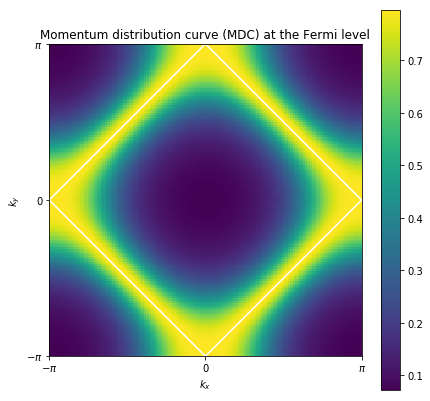

In [11]:
kgrid1d = np.linspace(-np.pi, np.pi, n_k+1, endpoint=True)  # a linear grid
kx, ky = np.meshgrid(kgrid1d, kgrid1d)                      # a 2d grid of points from numpy 

spectral = lambda kx, ky: -g0( (kx,ky,0), 0).imag
fs = lambda kx, ky: (1/g0( (kx,ky,0) , 0)).real

plt.figure(figsize=(7,7))
plt.pcolor(kx, ky, np.vectorize(spectral)(kx,ky))
plt.colorbar()
plt.contour(kx, ky, np.vectorize(fs)(kx,ky), levels=[0], colors='white')
plt.axes().set_aspect('equal')

# Cosmetics
plt.xticks([-np.pi, 0, np.pi],[r"$-\pi$", r"0", r"$\pi$"])    
plt.yticks([-np.pi, 0, np.pi],[r"$-\pi$", r"0", r"$\pi$"])
plt.xlabel(r"$k_x$"); plt.ylabel(r"$k_y$")
plt.title("Momentum distribution curve (MDC) at the Fermi level")

## Slices

Given a function $g(k,\omega)$, for a given $k_0$, it is possible to obtain
the function $\omega \rightarrow g(k_0, \omega)$ with the following command:


In [17]:
k0 = (0.02,0.01,0)      # a k point as a tuple of 3 floats
gw = g0(k0, all)        # We use the "built-in" function all here as equivalent of :, 
                        # which Python does not permit in ()
print gw   
print g0(np.array((0,0,0)),0)
assert gw.mesh == g0.mesh[1]            # The meshes corresponds !
assert abs(gw(0) - g0(k0, 0)) < 1.e-14  # Partially evaluate the function or directly evaluate is the same

Green Function  with mesh Matsubara Freq Mesh of size 256, Domain: Matsubara domain with beta = 2.5, statistic = Fermion, positive_only : 0 and target_rank 0: 

(0.227542459412-0.0714845718867j)


The new function is interpolated linearly for the point $k_0$ on the grid.

## Fermi surface, $n_k$
Using this technique, plot $n(k)$ along the diagonal of the Brillouin Zone to
see the Fermi surface


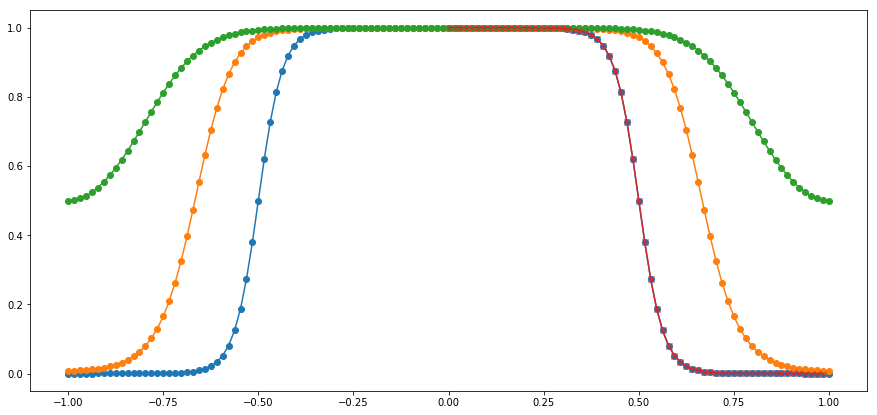

In [13]:
plt.figure(figsize=(15,7))

# function k-> g0(k, :) and take the density
for angle in [1, 0.5, 0]: 
    d = lambda k: g0 ( (k, angle*k,0),all).density().real
    plt.plot(kgrid1d/pi, np.vectorize(d)(kgrid1d), '-o')

# Internal check, not part of the question
# We replot using the point *on the grid* directly.  Idx(0,0,0) is the indices on the grid 
if 1: 
    d = lambda k: g0[Idx(k,k,0),:].density().real 
    kr = range(n_k/2)
    plt.plot([x /(n_k/2.0) for x in kr], np.vectorize(d)(kr), '-x')
